In [1]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

DATA_DIR = '/kaggle/input/celebrities-100k/100k'
print(len(os.listdir(DATA_DIR+'/100k')))

100000


In [3]:
print(os.listdir(DATA_DIR+'/100k')[:10])

['168202.jpg', '059339.jpg', '039337.jpg', '102631.jpg', '042195.jpg', '157069.jpg', '011035.jpg', '163198.jpg', '104821.jpg', '099103.jpg']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

In [5]:
train_ds = ImageFolder(root=DATA_DIR, 
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size), # pick central square crop of it
                                            T.ToTensor(),
                                            T.Normalize(*stats)        # normalize => -1 to 1                               
                                        ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=16):
  fig, ax = plt.subplots(figsize=(4,4))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))
  
def show_batch(dl, nmax=16):
  for images, _ in dl:
    show_images(images, nmax)
    break

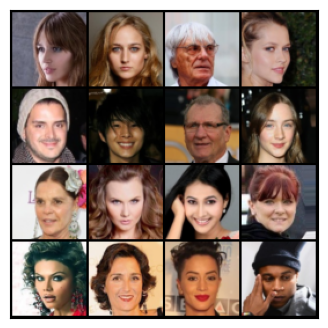

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [12]:
discriminator = to_device(discriminator, device)

In [13]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'  output shape: \t',X.shape)

Conv2d   output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d   output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU   output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d   output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d   output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU   output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d   output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d   output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU   output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d   output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d   output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU   output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d   output shape: 	 torch.Size([1, 1, 1, 1])
Flatten   output shape: 	 torch.Size([1, 1])
Sigmoid   output shape: 	 torch.Size([1, 1])


In [14]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


torch.Size([128, 3, 64, 64])


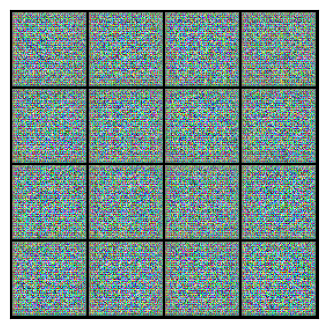

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device) # move generator to device

In [17]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)
    
  discriminator.trainable = False

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator 
  loss.backward()
  opt_g.step()

  return loss.item()

In [19]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

Saving generated=images-0000.png


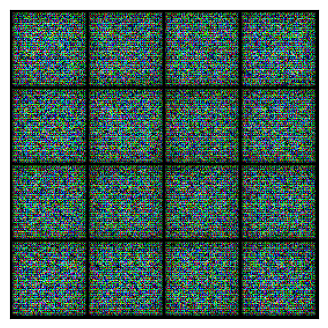

In [22]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)


In [23]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [24]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [25]:
# Hyperparameters
lr = 0.00025
epochs = 60

history = fit(epochs, lr)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 3.7357, loss_d: 0.4203, real_score: 0.7178, fake_score: 0.0487
Saving generated=images-0001.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 5.0153, loss_d: 0.6095, real_score: 0.8942, fake_score: 0.3501
Saving generated=images-0002.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 3.6117, loss_d: 0.3829, real_score: 0.8698, fake_score: 0.1971
Saving generated=images-0003.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 5.8426, loss_d: 0.8481, real_score: 0.9636, fake_score: 0.5086
Saving generated=images-0004.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 4.6053, loss_d: 0.3488, real_score: 0.9536, fake_score: 0.2447
Saving generated=images-0005.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 6.0735, loss_d: 0.7577, real_score: 0.9803, fake_score: 0.4705
Saving generated=images-0006.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 2.7417, loss_d: 0.2448, real_score: 0.8510, fake_score: 0.0644
Saving generated=images-0007.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 3.6211, loss_d: 0.1659, real_score: 0.9638, fake_score: 0.1151
Saving generated=images-0008.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 5.5379, loss_d: 0.0659, real_score: 0.9608, fake_score: 0.0243
Saving generated=images-0009.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 2.8517, loss_d: 0.3589, real_score: 0.9425, fake_score: 0.2346
Saving generated=images-0010.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 5.7794, loss_d: 0.3967, real_score: 0.9895, fake_score: 0.2906
Saving generated=images-0011.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 2.6181, loss_d: 0.1418, real_score: 0.9353, fake_score: 0.0635
Saving generated=images-0012.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 3.4195, loss_d: 0.1229, real_score: 0.9323, fake_score: 0.0477
Saving generated=images-0013.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 3.1114, loss_d: 0.3019, real_score: 0.8563, fake_score: 0.1144
Saving generated=images-0014.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 4.5881, loss_d: 0.0800, real_score: 0.9416, fake_score: 0.0172
Saving generated=images-0015.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 5.1375, loss_d: 0.1778, real_score: 0.9694, fake_score: 0.1249
Saving generated=images-0016.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 3.6155, loss_d: 0.1664, real_score: 0.9325, fake_score: 0.0818
Saving generated=images-0017.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 4.7141, loss_d: 0.2480, real_score: 0.9420, fake_score: 0.1475
Saving generated=images-0018.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.9096, loss_d: 0.0758, real_score: 0.9602, fake_score: 0.0297
Saving generated=images-0019.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 3.7787, loss_d: 0.2255, real_score: 0.8479, fake_score: 0.0454
Saving generated=images-0020.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 5.3032, loss_d: 0.1704, real_score: 0.9941, fake_score: 0.1314
Saving generated=images-0021.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 1.8902, loss_d: 0.5081, real_score: 0.7382, fake_score: 0.1366
Saving generated=images-0022.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 2.6305, loss_d: 0.2286, real_score: 0.8811, fake_score: 0.0827
Saving generated=images-0023.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 3.2264, loss_d: 0.1376, real_score: 0.9393, fake_score: 0.0595
Saving generated=images-0024.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 1.6609, loss_d: 0.5441, real_score: 0.6630, fake_score: 0.0044
Saving generated=images-0025.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.3510, loss_d: 0.0762, real_score: 0.9729, fake_score: 0.0437
Saving generated=images-0026.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 2.1221, loss_d: 0.6075, real_score: 0.6520, fake_score: 0.0413
Saving generated=images-0027.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 5.4346, loss_d: 0.3685, real_score: 0.9934, fake_score: 0.2354
Saving generated=images-0028.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 5.0303, loss_d: 0.1499, real_score: 0.9711, fake_score: 0.0943
Saving generated=images-0029.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.1436, loss_d: 0.1554, real_score: 0.8897, fake_score: 0.0279
Saving generated=images-0030.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 6.8841, loss_d: 0.4785, real_score: 0.9935, fake_score: 0.3176
Saving generated=images-0031.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.5492, loss_d: 0.3261, real_score: 0.8557, fake_score: 0.0879
Saving generated=images-0032.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 3.9703, loss_d: 0.1930, real_score: 0.8660, fake_score: 0.0066
Saving generated=images-0033.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 2.3951, loss_d: 0.2188, real_score: 0.8996, fake_score: 0.0762
Saving generated=images-0034.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 6.0500, loss_d: 0.0251, real_score: 0.9940, fake_score: 0.0184
Saving generated=images-0035.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 2.6186, loss_d: 0.3378, real_score: 0.8607, fake_score: 0.1415
Saving generated=images-0036.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 4.3895, loss_d: 0.0965, real_score: 0.9276, fake_score: 0.0140
Saving generated=images-0037.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 5.7276, loss_d: 0.0482, real_score: 0.9986, fake_score: 0.0426
Saving generated=images-0038.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 4.8175, loss_d: 0.0357, real_score: 0.9850, fake_score: 0.0195
Saving generated=images-0039.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 1.5216, loss_d: 0.3700, real_score: 0.7930, fake_score: 0.0906
Saving generated=images-0040.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 5.6392, loss_d: 0.0174, real_score: 0.9956, fake_score: 0.0126
Saving generated=images-0041.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 4.6983, loss_d: 0.1329, real_score: 0.9235, fake_score: 0.0428
Saving generated=images-0042.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 4.2528, loss_d: 0.0537, real_score: 0.9495, fake_score: 0.0008
Saving generated=images-0043.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 6.8948, loss_d: 0.5395, real_score: 0.9836, fake_score: 0.3057
Saving generated=images-0044.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 3.4640, loss_d: 0.0988, real_score: 0.9444, fake_score: 0.0346
Saving generated=images-0046.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 5.5184, loss_d: 0.0449, real_score: 0.9988, fake_score: 0.0396
Saving generated=images-0047.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 5.2806, loss_d: 0.0590, real_score: 0.9523, fake_score: 0.0075
Saving generated=images-0048.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.0140, loss_d: 0.3568, real_score: 0.8703, fake_score: 0.1382
Saving generated=images-0049.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 4.3256, loss_d: 0.1727, real_score: 0.9600, fake_score: 0.1061
Saving generated=images-0050.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 3.4023, loss_d: 0.0871, real_score: 0.9502, fake_score: 0.0244
Saving generated=images-0051.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 5.8208, loss_d: 0.0442, real_score: 0.9728, fake_score: 0.0153
Saving generated=images-0052.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 2.8510, loss_d: 0.2853, real_score: 0.8262, fake_score: 0.0534
Saving generated=images-0053.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 0.0051, loss_d: 2.5925, real_score: 0.1804, fake_score: 0.0002
Saving generated=images-0054.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 3.7138, loss_d: 0.7525, real_score: 0.5669, fake_score: 0.0085
Saving generated=images-0055.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 6.1298, loss_d: 0.0593, real_score: 0.9972, fake_score: 0.0464
Saving generated=images-0056.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 0.2510, loss_d: 4.6154, real_score: 0.0714, fake_score: 0.0065
Saving generated=images-0057.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 6.5362, loss_d: 0.0110, real_score: 0.9975, fake_score: 0.0083
Saving generated=images-0058.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 2.2212, loss_d: 0.5034, real_score: 0.7673, fake_score: 0.1055
Saving generated=images-0059.png


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 5.8922, loss_d: 0.3466, real_score: 0.9634, fake_score: 0.1991
Saving generated=images-0060.png


In [26]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')
losses_g, losses_d, real_scores, fake_scores = history


In [27]:
from IPython.display import Image

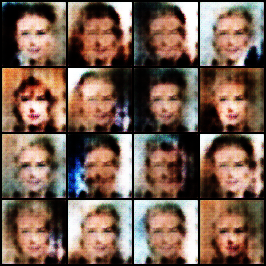

In [28]:
Image('./generated/generated=images-0001.png')


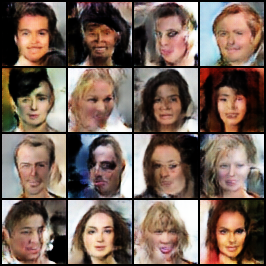

In [29]:
Image('./generated/generated=images-0005.png')

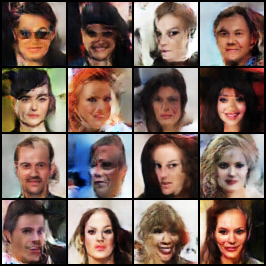

In [30]:
Image('./generated/generated=images-0010.png')


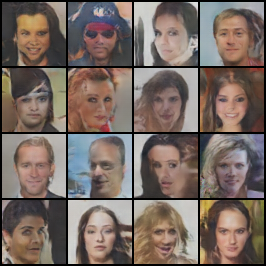

In [31]:
Image('./generated/generated=images-0030.png')


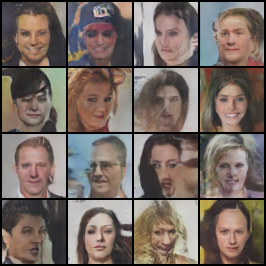

In [32]:
Image('./generated/generated=images-0040.png')


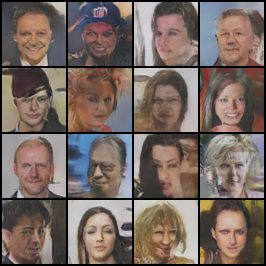

In [33]:
Image('./generated/generated=images-0060.png')


In [34]:
import cv2
import os

vid_fname = 'gans_training.avi'

print("Starting converting images to video.")
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

print(files)

fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fname,fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

Starting converting images to video.
['generated/generated=images-0000.png', 'generated/generated=images-0001.png', 'generated/generated=images-0002.png', 'generated/generated=images-0003.png', 'generated/generated=images-0004.png', 'generated/generated=images-0005.png', 'generated/generated=images-0006.png', 'generated/generated=images-0007.png', 'generated/generated=images-0008.png', 'generated/generated=images-0009.png', 'generated/generated=images-0010.png', 'generated/generated=images-0011.png', 'generated/generated=images-0012.png', 'generated/generated=images-0013.png', 'generated/generated=images-0014.png', 'generated/generated=images-0015.png', 'generated/generated=images-0016.png', 'generated/generated=images-0017.png', 'generated/generated=images-0018.png', 'generated/generated=images-0019.png', 'generated/generated=images-0020.png', 'generated/generated=images-0021.png', 'generated/generated=images-0022.png', 'generated/generated=images-0023.png', 'generated/generated=image

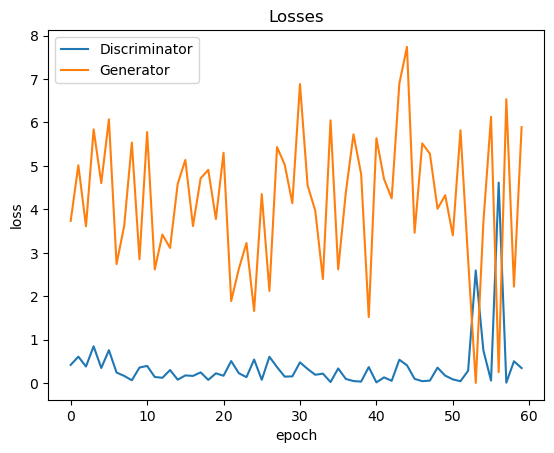

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

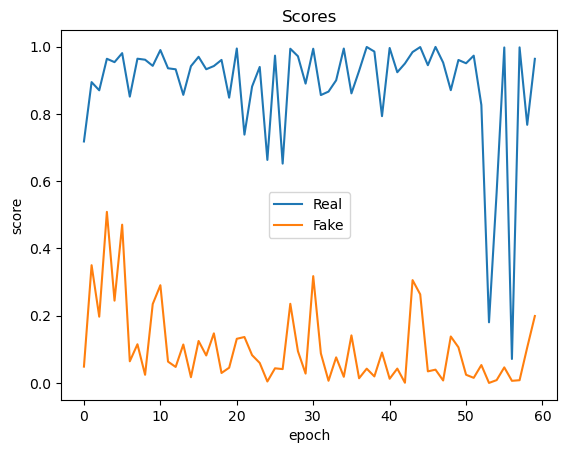

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');